# Analysis of Preprint Papers from the ArXiv

The website [arxiv.org](https://arxiv.org) is a popular database for scientific papers in STEM fields. ArXiv has its own classification system consisting of roughly 150 different categories, which are manually added by the authors whenever a new paper is uploaded. A paper can be assigned multiple categories.

The goal for this project is to develop a machine learning model which can predict the ArXiv category from a given title and abstract.

We start by importing all the packages we will need and setting up a data directory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # used for handling files
from sklearn.decomposition import PCA # dimension reduction of data
import pickle # saving models
from pathlib import Path # to get home directory

# local files
import arxiv_scraper
import cleaner
import elmo
import NN
import onehot

print("Packages loaded.")

W0725 08:43:17.575109 139834573195072 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Packages loaded.


The data set used here has been scraped from the [ArXiv API](https://arxiv.org/help/api) over several days, using the Python scraper `arxiv_scraper.py`. To get a sense for how long the scraping takes, you can uncomment and run the script below.

In [2]:
#arxiv_scraper.cat_scrape(
#    max_results_per_cat = 100, # maximum number of papers to download per category (there are ~150 categories)
#    file_path = "arxiv_data", # name of output file
#    batch_size = 100 # size of every batch - lower batch size requires less memory - must be less than 30,000
#)

Alternatively, I have downloaded metadata from about a million papers using this scraper (with `max_results_per_cat` = 10000), which can be freely downloaded below. This data set takes up ~1gb of space, however, so I've included many random samples of this data set as well:

* `arxiv` contains the main data set
* `arxiv_sample_1000` contains 1,000 papers
* `arxiv_sample_5000` contains 5,000 papers
* `arxiv_sample_10000` contains 10,000 papers
* `arxiv_sample_25000` contains 25,000 papers
* `arxiv_sample_50000` contains 50,000 papers
* `arxiv_sample_100000` contains 100,000 papers
* `arxiv_sample_200000` contains 200,000 papers
* `arxiv_sample_500000` contains 500,000 papers
* `arxiv_sample_750000` contains 750,000 papers

Choose your favorite below. Alternatively, of course, you can set it to be the file name of your own scraped data.

In [3]:
file_name = "arxiv_sample_1000"

Next up, we specify the folder in which we will store all our data. Change to whatever folder you would like.

In [4]:
home_dir = str(Path.home())
data_path = os.path.join(home_dir, "pCloudDrive", "Public Folder", "scholarly_data")

## Fetching data

We then do some basic setting up.

In [5]:
# create path directory and download a list of all arXiv categories
cleaner.setup(data_path)

# download the raw titles and abstracts
cleaner.download_papers(file_name, data_path)

cats.csv is already downloaded.
arxiv_sample_1000.csv is already downloaded.


Next, we store the list of arXiv categories.

In [6]:
# construct category dataframe and array
full_path = os.path.join(data_path, "cats.csv")
cats_df = pd.read_csv(full_path)
cats = np.asarray(cats_df['category'].values)

pd.set_option('display.max_colwidth', 50)
cats_df.head()

,category,description
0,astro-ph,Astrophysics
1,astro-ph.CO,Cosmology and Nongalactic Astrophysics
2,astro-ph.EP,Earth and Planetary Astrophysics
3,astro-ph.GA,Astrophysics of Galaxies
4,astro-ph.HE,High Energy Astrophysical Phenomena


## Cleaning the data

We now do some basic cleaning operations on our raw data. We convert strings '\[cat_1, cat_2\]' into actual lists \[cat_1, cat_2\], make everything lower case, removing punctuation, numbers and whitespace, and dropping NaN rows.

Our last text cleaning step is to lemmatise the text, which reduces all words to its base form. For instance, 'eating' is converted into 'eat' and 'better' is converted into 'good'. This usually takes a while to finish, so instead we're simply going to download a lemmatised version of your chosen data set. Alternatively, if you're dealing with your own scraped data set, you can uncomment the marked lines below.

In [7]:
full_path = os.path.join(data_path, f"{file_name}_clean.csv")
if not os.path.isfile(full_path):
    # preclean raw data and save the precleaned texts and
    # categories to {file_name}_preclean.csv
    cleaner.get_preclean_text(file_name, data_path)

    # lemmatise precleaned data and save lemmatised texts to 
    # {file_name}_clean.csv and delete the precleaned file
    cleaner.lemmatise_file(file_name, batch_size = 1000, path = data_path, confirmation = False)

# load in cleaned text
print("Loading cleaned text...")
full_path = os.path.join(data_path, f"{file_name}_clean.csv")
clean_text = pd.read_csv(full_path, delimiter = '\n', header = None)
clean_df = pd.DataFrame(clean_text)
clean_df.columns = ['clean_text']

# load in cats and add them to df
full_path = os.path.join(data_path, f"{file_name}_cats.csv")
clean_cats_with_path = lambda x: cleaner.clean_cats(x, path = data_path)
cleaned_cats = pd.read_csv(full_path, header = None, converters = {0 : clean_cats_with_path})

# join the two dataframes
clean_df['category'] = cleaned_cats.iloc[:, 0]

print(f"Shape of clean_df: {clean_df.shape}. Here are some of the lemmatised texts:")
pd.set_option('display.max_colwidth', 1000)
clean_df[['clean_text', 'category']].head()

Loading cleaned text...
Shape of clean_df: (1000, 2). Here are some of the lemmatised texts:


,clean_text,category
0,"on invariant graph subspace in this paper -PRON- discuss the problem of decomposition for unbounded $ \times $ operator matrix by a pair of complementary invariant graph subspace . under mild additional assumption , -PRON- show that such a pair of subspace decompose the operator matrix if and only if -PRON- domain be invariant for the angular operator associate with the graphs . as a byproduct of -PRON- consideration , -PRON- suggest a new block diagonalization procedure that resolve related domain issue . in the case when only a single invariant graph subspace be available , -PRON- obtain block triangular representation for the operator matrix .","[math.FA, math.SP]"
1,"on a perturbation theory of hamiltonian system with periodic coefficient a theory of rank $ k\ge $ perturbation of symplectic matrix and hamiltonian system with periodic coefficient use a base of isotropic subspace , be present . after show that the fundamental matrix $ { \displaystyle \left(\widetilde{x}(t)\right)_{t\ge } } $ of the rank $ k$ perturbation of hamiltonian system with periodic coefficient and the rank $ k$ perturbation of the fundamental matrix $ { \displaystyle \left(x(t)\right)_{t\ge } } $ of the unperturbed system be the same , the jordan canonical form of $ { \displaystyle \left(\widetilde{x}(t)\right)_{t\ge } } $ be give . two numerical example illustrate this theory and the consequence of rank $ k$ perturbation on the strong stability of hamiltonian system be also give .",[math.NA]
2,"restriction theorem on métiver group associate to joint functional calculus in this article , -PRON- get the spectral solution $ \mathcal{p}_{\mu}^{m}$ of operator $ m(\mathcal{l } , -\delta_\mathfrak{z})$ , the joint functional calculus of the sub - laplacian and laplacian on the centre of m\'etivier group . then , -PRON- give some group - analogue of the thomas - stein - type restriction theorem , assert the mix - norm boundness of the restriction operator $ \mathcal{p}_{\mu}^{m}$ for two class of function $ m=(a^\alpha+b^\beta)^\gamma$ and $ m= ( + a^\alpha+b^\beta)^\gamma$ with $ \alpha , \beta > , \gamma\neq $ .","[math.FA, math.SP]"
3,"count solution of the bethe equation of the quantum group invariant open xxz chain at root of unity -PRON- consider the sl ( ) _ q - invariant open spin- / xxz quantum spin chain of finite length n. for the case that q be a root of unity , -PRON- propose a formula for the number of admissible solution of the bethe ansatz equation in term of dimension of irreducible representation of the temperley - lieb algebra ; and a formula for the degeneracy of the transfer matrix eigenvalue in term of dimension of tilt sl ( ) _ q - module . these formula include correction that appear if two or more tilting module be spectrum - degenerate . for the xx case ( q = exp(i pi/ ) ) , -PRON- give explicit formula for the number of admissible solution and degeneracy . -PRON- also consider the case of generic q and the isotropic ( q- > ) limit . numerical solution of the bethe equation up to n= be present . -PRON- result be consistent with the bethe ansatz solution be complete .","[cond-mat.stat-mech, hep-th, math-ph, math.MP, math.QA, math.RT]"
4,"current - induced force for nonadiabatic molecular dynamic -PRON- present general first principle derivation of expression for current - induced force . the expression be applicable in non - equilibrium molecular system with arbitrary intra - molecular interaction and for any electron - nuclei coupling . -PRON- provide a control consistent way to account for quantum effect of nuclear motion , account for electronic non - markov character of the friction tensor , and open way to treatment beyond strictly adiabatic approximation . -PRON- show connection of the expression with previous study , and discuss effective way to evaluate the friction tensor .",[cond-mat.mes-hall]


## ELMo feature extraction

To build our model we have to extract features from the titles and abstracts. We will be using ELMo, a state-of-the-art NLP framework developed by AllenNLP, which converts text input into vectors, with similar words being closer to each other. We will first download the ELMo model. It is over 350mb in size, so it might take a little while.

In [8]:
elmo.download_elmo_model()

ELMo model already downloaded.


We now need to extract ELMo features from our cleaned text data. This is done using the `extract` function from `elmo.py`. This usually takes a LONG time.

In [9]:
full_path = os.path.join(data_path, f"{file_name}_elmo.csv")
if not os.path.isfile(full_path):
    # extract ELMo data
    elmo.extract(
        file_name = file_name,
        path = data_path,
        batch_size = 20, # lower batch size gives less accurate vectors but requires less memory
        doomsday_clock = 50,
        confirmation = False
    )

# load ELMo data
print("Loading ELMo'd text...")
full_path = os.path.join(data_path, f"{file_name}_elmo.csv")
elmo_data = pd.read_csv(full_path, header = None)
print(f"ELMo data loaded from {full_path}.")

elmo_df = clean_df.copy()
elmo_df = elmo_data.join(elmo_df['category'])

print(f"Shape of elmo_df: {elmo_df.shape}")
elmo_df.head()

Loading ELMo'd text...
ELMo data loaded from /home/leidem/pCloudDrive/Public Folder/scholarly_data/arxiv_sample_1000_elmo.csv.
Shape of elmo_df: (1000, 1025)


,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,category
0,0.074258,0.053287,0.003422,-0.041465,0.004408,-0.113955,-0.008332,0.106393,-0.005394,-0.163931,...,0.033487,0.050138,0.054076,0.149214,0.009285,0.298747,-0.061044,0.047769,-0.061565,"[math.FA, math.SP]"
1,0.017573,-0.034118,0.024567,-0.044752,0.045088,-0.019229,-0.036770,0.114171,-0.082530,-0.142344,...,0.050569,0.125177,0.061317,0.174147,-0.032256,0.281019,-0.081716,0.072077,-0.032726,[math.NA]
2,0.022622,0.061201,0.004247,-0.035245,0.049027,0.042078,-0.060435,0.254118,0.045122,-0.158472,...,0.064181,0.063693,0.104312,0.155864,-0.073906,0.124841,-0.020620,0.100988,0.018736,"[math.FA, math.SP]"
3,0.097701,0.176630,0.068282,-0.110465,0.027969,-0.095012,-0.013059,0.323077,0.023147,-0.206294,...,0.071225,0.090191,0.085636,0.211089,-0.002569,0.501484,-0.137235,0.205268,0.038047,"[cond-mat.stat-mech, hep-th, math-ph, math.MP, math.QA, math.RT]"
4,-0.013715,0.130801,-0.034975,0.033820,0.066397,-0.097841,-0.053235,0.082990,0.122556,-0.174439,...,0.038224,-0.045697,0.093033,0.120280,0.056584,0.322031,-0.050372,0.133250,0.040734,[cond-mat.mes-hall]


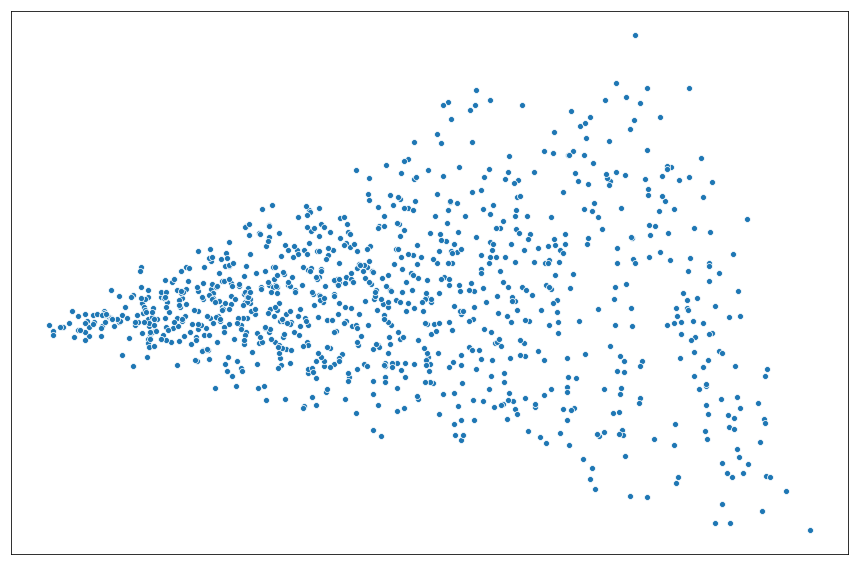

In [10]:
n = elmo_df.shape[1] - 1
X = np.asarray(elmo_df.iloc[:, :n])
X_2d = PCA(n_components = 2).fit_transform(X)
elmo_2d = pd.DataFrame(X_2d, columns = ['x', 'y'])

fig, ax = plt.subplots(1, figsize = (15, 10))
ax.set_xticks([])
ax.set_yticks([])
sns.scatterplot(data = elmo_2d, x = 'x', y = 'y')

## One-hot encoding of categories

We then perform a one hot encoding for the category variable, as this will make training our model easier. We do this by first creating a dataframe with columns the categories and binary values for every paper, and then concatenate our original dataframe with the binary values.

In [11]:
# one-hot encode aggregated categories
onehot.one_hot_agg(file_name, data_path)

# load data
print("Loading aggregated category data...")
full_path = os.path.join(data_path, f"{file_name}_1hot_agg.csv")
df_1hot_agg = pd.read_csv(full_path)
print(f"Aggregated category data loaded.")

# show the new columns of the data frame
pd.set_option('display.max_colwidth', 10)
print(f"Dimensions of df_1hot_agg: {df_1hot_agg.shape}.")
df_1hot_agg.head()

File already one-hot encoded.
Loading aggregated category data...
Aggregated category data loaded.
Dimensions of df_1hot_agg: (1000, 1029).


,0,1,2,3,4,5,6,7,8,9,...,1019,1020,1021,1022,1023,physics,other,cs,math,stats
0,0.074258,0.053287,0.003422,-0.041465,0.004408,-0.113955,-0.008332,0.106393,-0.005394,-0.163931,...,0.009285,0.298747,-0.061044,0.047769,-0.061565,0,0,0,1,0
1,0.017573,-0.034118,0.024567,-0.044752,0.045088,-0.019229,-0.036770,0.114171,-0.082530,-0.142344,...,-0.032256,0.281019,-0.081716,0.072077,-0.032726,0,0,0,1,0
2,0.022622,0.061201,0.004247,-0.035245,0.049027,0.042078,-0.060435,0.254118,0.045122,-0.158472,...,-0.073906,0.124841,-0.020620,0.100988,0.018736,0,0,0,1,0
3,0.097701,0.176630,0.068282,-0.110465,0.027969,-0.095012,-0.013059,0.323077,0.023147,-0.206294,...,-0.002569,0.501484,-0.137235,0.205268,0.038047,1,1,0,1,0
4,-0.013715,0.130801,-0.034975,0.033820,0.066397,-0.097841,-0.053235,0.082990,0.122556,-0.174439,...,0.056584,0.322031,-0.050372,0.133250,0.040734,0,1,0,0,0


## Analysis of the data

Here is how the categories in our data set are distributed.

We see that our data is not particularly uniformly distributed. These are the categories with the most amount of papers in the data set.

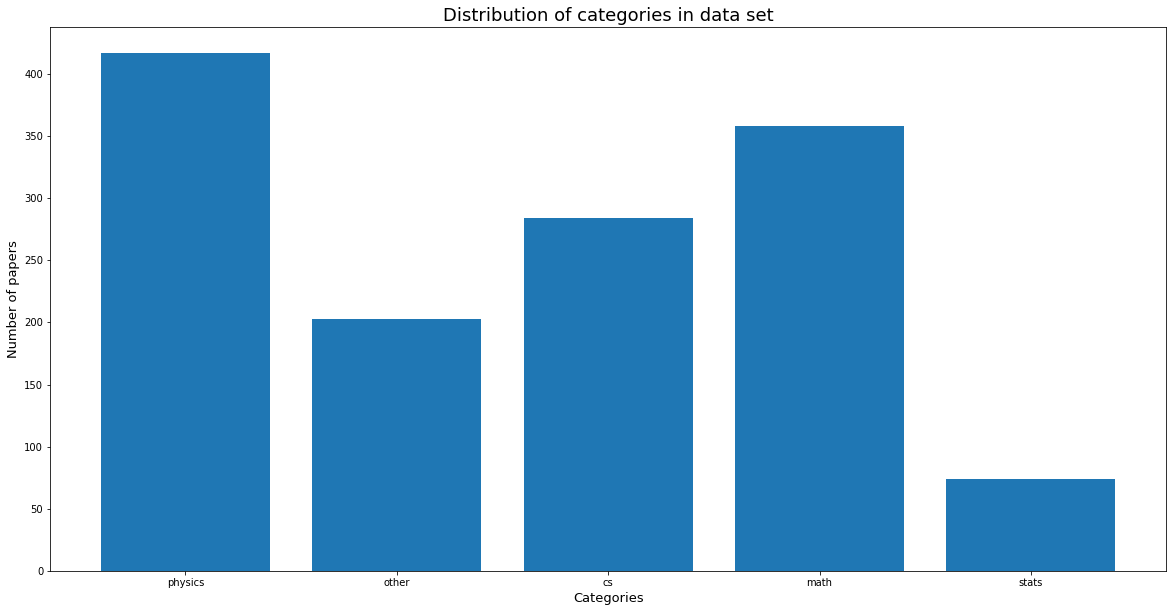

In [12]:
# save a dataframe with the amount of papers in each category
sum_cats = df_1hot_agg.iloc[:, 1024:].apply(lambda x: x.sum())

# plot the distribution of the amount of papers in each category
plt.figure(figsize = (20,10))
plt.bar(x = sum_cats.keys(), height = sum_cats.values)
plt.xlabel('Categories', fontsize = 13)
plt.ylabel('Number of papers', fontsize = 13)
plt.title('Distribution of categories in data set', fontsize = 18)
plt.show()

## Building a model

We are now done manipulating our data, and the time has come to build a model.

In [16]:
# number of gradient descent iterations
iterations = 25000

full_path = os.path.join(data_path, f'{file_name}_model_{iterations}.pickle')
if os.path.isfile(full_path):
    with open(full_path, 'rb') as pickle_in:
        nn_model = pickle.load(pickle_in)
else:
    nn_model = NN.NeuralNetwork(
        layer_dims = [500, 5],
        activations = ['tanh', 'sigmoid'],
        learning_rate = 0.0075,
        num_iterations = iterations,
        cost_function = 'binary_cross_entropy',
        plot_cost = True,
        init_method = 'he'
    )

    full_path = os.path.join(data_path, f"{file_name}_1hot_agg.csv")
    df_1hot_agg = pd.read_csv(full_path)

    X = np.asarray(df_1hot_agg.iloc[:, :1024]).T
    y = np.asarray(df_1hot_agg.iloc[:, 1024:]).T
    nn_model.fit(X, y)

    print("") # deal with \r
    print("Training complete!")

    full_path = os.path.join(data_path, f'{file_name}_model_{iterations}.pickle')
    with open(full_path, 'wb') as pickle_out:
        pickle.dump(nn_model, pickle_out)

    print(f"Model saved to {file_name}_model_{iterations}.pickle")
    
print("Model loaded.")

Performing gradient descent... 5000 iterations completed. Cost: 1.4930439852153108
Training complete!
Model saved to arxiv_sample_1000_model_5000.pickle
Model loaded.


In [17]:
X = np.asarray(df_1hot_agg.iloc[:, :1024]).T
y = np.asarray(df_1hot_agg.iloc[:, 1024:]).T

for i in np.arange(100):
    print(f'Paper number {i}:')
    print(f'Predicted: {nn_model.predict(X[:, i])}')
    print(f'Correct: {y[:, i]}')
    print("")

Paper number 0:
Predicted: [[0.12275226]
 [0.06738289]
 [0.45481935]
 [0.76423712]
 [0.07283435]]
Correct: [0 0 0 1 0]

Paper number 1:
Predicted: [[0.27361077]
 [0.06816489]
 [0.05696927]
 [0.91112591]
 [0.0175413 ]]
Correct: [0 0 0 1 0]

Paper number 2:
Predicted: [[0.13322965]
 [0.0370787 ]
 [0.07219523]
 [0.92925698]
 [0.04752657]]
Correct: [0 0 0 1 0]

Paper number 3:
Predicted: [[0.18637861]
 [0.07208265]
 [0.10305697]
 [0.93917062]
 [0.02422651]]
Correct: [1 1 0 1 0]

Paper number 4:
Predicted: [[0.54401056]
 [0.45304586]
 [0.04117918]
 [0.21365218]
 [0.07379597]]
Correct: [0 1 0 0 0]

Paper number 5:
Predicted: [[0.39131167]
 [0.1992896 ]
 [0.11297946]
 [0.05185643]
 [0.01202017]]
Correct: [0 1 0 0 0]

Paper number 6:
Predicted: [[0.7032979 ]
 [0.19886289]
 [0.04425261]
 [0.19986402]
 [0.00975729]]
Correct: [1 0 0 0 0]

Paper number 7:
Predicted: [[0.23297004]
 [0.08200513]
 [0.18740203]
 [0.63923985]
 [0.0527377 ]]
Correct: [1 0 0 0 0]

Paper number 8:
Predicted: [[0.22365922]